<a href="https://colab.research.google.com/github/Behzad-Iravani/OlfactoryBulb/blob/main/Odor_Air_animation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
%matplotlib inline
import numpy as np
import scipy.signal as sproc
from scipy.signal.windows import gaussian as gwin

import matplotlib.pyplot as plt
import matplotlib.animation as animation
from matplotlib.animation import FFMpegWriter
import matplotlib.font_manager as fm


In [ ]:
font = {'family' : 'monospace',
        'weight' : 'normal',
        'size'   : 14}

In [ ]:
from numpy.core.function_base import linspace
class Sig:

  def __init__(self,fsamp = 512, duration = 2, noise_scale= .1):
    self.fsamp = fsamp
    self.duration = duration
    self.noise_scale = noise_scale
    self.TC = np.zeros(self.duration*self.fsamp) + self.noise_scale*np.random.randn(self.duration*self.fsamp)
    self.time = np.linspace(-duration/2, duration/2, int(np.floor(duration*fsamp)))

  def add_os(self,amplitude, freq, onset, offset):
    if offset>onset:
      mid = (offset-onset)//2
    else:
      raise TypeError("Offset can't bigger than onset!")

    onset_indx = np.argmax(self.time>onset)
    offset_indx = np.argmax(self.time>offset)
    tc = np.zeros((self.fsamp*self.duration))

    time = np.linspace(onset, offset, len(tc[onset_indx:offset_indx]))
    s = amplitude*np.sin(2*np.pi*freq*time)
    tc[onset_indx:offset_indx] = s*gwin(offset_indx-onset_indx, 20)
    self.TC += tc

  def spect(self):
    f, t, Sxx = sproc.spectrogram(self.TC, self.fsamp, nperseg=32,noverlap = 32//2 , nfft = 64)
    for icol in range(Sxx.shape[1]):
      Sxx[:,icol] -= np.mean(Sxx[:,icol])
    return f, t, Sxx

In [ ]:
class anim:
  def __init__(self, fig, ax, Sxx, t, f, name):
    self.fig = fig
    self.ax = ax
    self.Sxx = Sxx
    self.t = t
    self.f = f
    self.line = None
    self.name = name

  def plot(self):

    img = self.ax.pcolormesh(self.t-2, self.f, self.Sxx, shading='gouraud', cmap= 'jet', vmin=-0.01, vmax=.05, zorder = 0)
    plt.ylabel('Frequency [Hz]')
    plt.xlabel('Time [sec]')
    plt.title(self.name)
    self.ax.set_ylim([40, 100])
    self.ax.set_xlim([-.2, 1])
    self.ax.set_aspect(.05)
    plt.subplots_adjust(bottom=0.25)
    self.line = plt.axvline(x = 0.0, color = 'w', linestyle = '-', zorder = 10)

    plt.rc('font', **font)
    plt.draw()
    return self.ax, self.line

  def save_anim(self):
    name_ = self.name
    metadata = dict(title= name_ , artist='Matplotlib',
                comment='Movie support!')
    writer = FFMpegWriter(fps=10, metadata=metadata)

    with writer.saving(self.fig, name_ +'.mp4', 100):
         for iseg in range(9*self.Sxx.shape[1]//5, 3*self.Sxx.shape[1]//4):

          self.line.set_xdata([self.t[iseg]-2.0, self.t[iseg]-2.0])
          plt.draw()
          writer.grab_frame()

  def wave(self,a,f):
    time = linspace(-1,1,512*2)
    s= a*np.sin(2*np.pi*f*time)*gwin(512*2, 60)
    return s

  def wave_viz(self):

    name_ = self.name + 'wave'
    metadata = dict(title= name_ , artist='Matplotlib',
                comment='Movie support!')
    writer = FFMpegWriter(fps=10, metadata=metadata)
    plt.close()
    fig, ax = plt.subplots(1,1,figsize=(3,3))
    with writer.saving(fig, name_ +'.mp4', 100):
      time = linspace(-1,1,512*2)
      for iseg in range(9*self.Sxx.shape[1]//5,3*self.Sxx.shape[1]//4):
        s = self.wave(np.mean(self.Sxx[:, iseg]), self.f[np.argmax(self.Sxx[:, iseg])]/2.0)
        if iseg == 0:
          line = ax.plot(time, s,  color = [.6, .6 ,.6])
          ax.set_aspect(.06)
        else:
          plt.cla()
          line = ax.plot(time, s,  color = [.6, .6 ,.6])
        plt.draw()
        plt.axis('off')
        plt.ylim([-7e-18, 7e-18])
        writer.grab_frame()

In [ ]:
# defin signals
orange = Sig(512, 4, .75)
# len(orange.time)
orange.add_os(2, 70, .1,.25)
orange.add_os(2, 65, .1,.25)
orange.add_os(2, 60, .1,.25)
# chocolate
chocolate = Sig(512, 4, .75)
chocolate.add_os(2, 45, .2, .35)
chocolate.add_os(2, 50, .2, .35)
chocolate.add_os(2, 42, .2, .35)
chocolate.add_os(2, 45, .8, .9)
# n.Butanol
N_butanol = Sig(512, 4, .75)
N_butanol.add_os(2, 80, .1, .25)
N_butanol.add_os(2, 85, .1, .25)
N_butanol.add_os(2, 40, .75, .95)
N_butanol.add_os(2, 45, .75, .95)
# air
air1 = Sig(512, 4, .5)
air2 = Sig(512, 4, .5)
air3 = Sig(512, 4, .5)

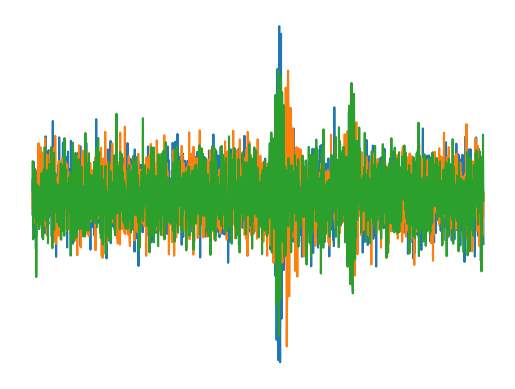

In [ ]:
plt.plot(orange.time,orange.TC)
plt.plot(chocolate.time,chocolate.TC)
plt.plot(N_butanol.time,N_butanol.TC)
plt.axis('off')
plt.rc('font', **font)

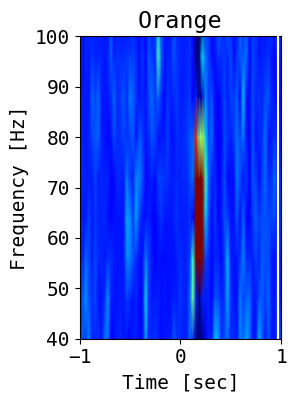

In [ ]:
fig, ax = plt.subplots(1,1);
f_, t_, Sxx_ = orange.spect()
ao = anim(fig, ax, Sxx_,t_,f_, "Orange")
ax, line = ao.plot()
# save anim for orange
ao.save_anim()

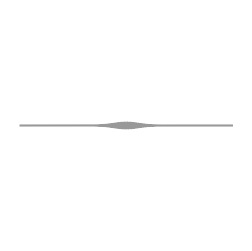

In [ ]:
ao.wave_viz()

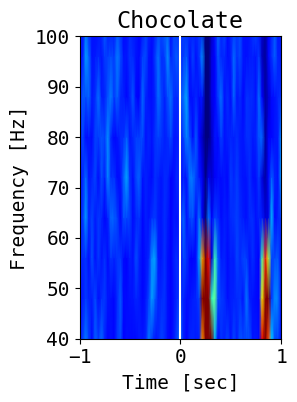

In [ ]:
fig, ax = plt.subplots();
f_, t_, Sxx_ = chocolate.spect()
ac = anim(fig, ax, Sxx_,t_,f_, "Chocolate")
ax, line = ac.plot()

In [ ]:
# save anim for chocolate
ac.save_anim()

<Figure size 640x480 with 0 Axes>

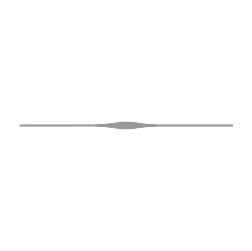

In [ ]:
ac.wave_viz()

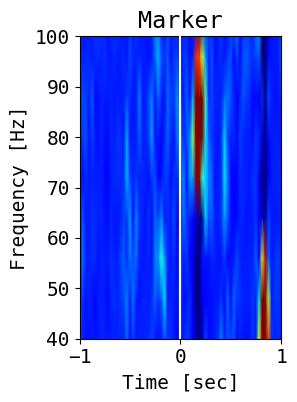

In [ ]:
fig, ax = plt.subplots();
f_, t_, Sxx_ = N_butanol.spect()
an = anim(fig, ax, Sxx_,t_,f_, "Marker")
ax, line = an.plot()

In [ ]:

# save anim for nbutanol
an.save_anim()


<Figure size 640x480 with 0 Axes>

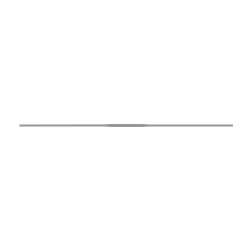

In [ ]:
an.wave_viz()

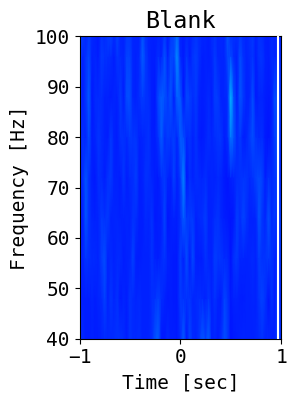

In [ ]:
fig, ax = plt.subplots(1,1);
f_, t_, Sxx_ = air1.spect()
a1 = anim(fig, ax, Sxx_,t_,f_, "Blank")
ax, line = a1.plot()
# save anim for orange
a1.save_anim()

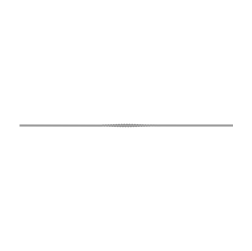

In [ ]:
a1.wave_viz()